<h1><center>Deep Learning</center></h1>
<h2><center>Assignment # 2</center></h2>
<h3><center>Task # 3</center></h3>

In [1]:
# Include libraries which may use in implementation
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
import sklearn.model_selection as sk
import PIL
import scipy.misc as img
import glob
import pickle
from sklearn.manifold import TSNE
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# Create a Neural_Network class
class Neural_Network(object):  
    def __init__(self,no_of_layers = 2,input_dim=784,neurons_per_layer = [128,64,10], activation = 'sigmoid'):
        self.activation = activation
        self.total_no_of_layers = no_of_layers + 1 + 1# +1 for input layer, +1 for output_layer
        self.neurons_per_layer = [input_dim] + neurons_per_layer # inserting input layer neurons for easier processing
        self.no_of_classes = self.neurons_per_layer[-1] #saving no_of_classes for later use
        self.weights = []
        self.biases = []
        for i in range(len(self.neurons_per_layer)-1):
            weights = np.random.randn(self.neurons_per_layer[i+1],self.neurons_per_layer[i] )#*0.25 #one weight vector for every neuron
            biases = np.random.randn(self.neurons_per_layer[i+1],1)# *0.25
            self.weights.append(weights)
            self.biases.append(biases)

    def sigmoid(self, s):
        # activation function
        return (1/(1+np.exp(-s))) #? # apply sigmoid function on s and return it's value

    def sigmoid_derivative(self, s):
        #derivative of sigmoid
        return self.sigmoid(s)*(1-self.sigmoid(s)) #? # apply derivative of sigmoid on s and return it's value 
    
    def tanh(self, s):
        # activation function
        return np.tanh(s) #? # apply tanh function on s and return it's value

    def tanh_derivative(self, s):
        #derivative of tanh
        return (1-(self.tanh(s))**2) #? # apply derivative of tanh on s and return it's value
    
    def relu(self, s):
        # activation function
        #print(s)
        return np.maximum(0, s)

    def relu_derivative(self, s):
        #derivative of relu
        #print(s)
        return np.greater(s, 0).astype(int)
    
    def leaky_relu(self, s):
        s[s < 0] *= .01
        return s

    def leaky_relu_derivative(self, s):
        s[s < 0] *= .01
        s[s > 0] = (int)(1)
        return s
              
    def softmax(self, output):
        exp = np.exp(output - np.max(output))
        #exp = np.exp(output)
        output_softmax = exp/np.sum(exp)
        return output_softmax
    
    def feedforward(self, x, keep_prob=0.8, train = False): 
        x = x.reshape(x.shape[0],1)
        #print('x.shape')
        #print(x.shape)
        layer_wise_z = [] # z = wx+b # for all layers
        layer_wise_a = [] # inputs of all layers
        layer_wise_dropout_masks = [] # for hidden_layers only
        layer_input = x
        layer_wise_a.append(x) # first input is input data itself, saving for later use

        h_l = 1 # variable to track hidden layers to use dropout
        for weights,biases in zip(self.weights, self.biases):
            #print('weights.shape')
            #print(weights.shape)
            #print('layer_input.shape')
            #print(layer_input.shape)
            #print('biases.shape')
            #print(biases.shape)
            z = np.dot(weights, layer_input)+biases
            #print("z.shape")
            #print(z.shape)
            if (h_l>1) and (h_l<len(self.weights)): # no dropout for first hidden layer, it gets all the input values
                if train:                             # no dropout for output layer
                    dropout_mask=(np.random.rand(*z.shape)< keep_prob)/keep_prob
                    #print('dropout_mask.shape')
                    #print(dropout_mask.shape)
                    z *= dropout_mask
                    #print('after dropout, z.shape')
                    #print(z.shape)
                    layer_wise_dropout_masks.append(dropout_mask)
            
            layer_wise_z.append(z)
            h_l = h_l+1
            
            if self.activation == 'sigmoid':
                layer_input = self.sigmoid(z)
            elif self.activation == 'tanh':
                layer_input = self.tanh(z)
            elif self.activation == 'relu':
                layer_input = self.leaky_relu(z)
            else:
                print("unknown activation function")
            layer_wise_a.append(layer_input)
        
        return layer_wise_z,layer_wise_a,layer_wise_dropout_masks
    

    def backpropagation(self,z,a,dropout_masks,x,y):
        # converting label to one hot encoded vector to compare with output of network
        one_hot_y = self.onehotencoder(y)     
        
        layer_wise_z = z
        layer_wise_a = a
        layer_wise_dropout_masks = dropout_masks
        
        # softmax on last layer's output
        layer_wise_a[-1] = self.softmax(layer_wise_a[-1])
        
        # empty arrays for weights and biases gradients initialized with zero.
        layer_wise_dw = []
        layer_wise_db = []
        for weights in self.weights:
            layer_wise_dw.append(np.zeros(weights.shape))
        for biases in self.biases:
            layer_wise_db.append(np.zeros(biases.shape))
        
        # gradients at output layer
        dz = (layer_wise_a[-1]- one_hot_y) * self.sigmoid_derivative(layer_wise_z[-1])
        layer_wise_dw[-1] = np.dot(dz, layer_wise_a[-2].T)
        layer_wise_db[-1] = dz
        
        overall_layer_index = self.total_no_of_layers - 1  # after computing gradients of last layer i'm at second last layer 
        hidden_layer_index  =  overall_layer_index - 1                # which is actually last hidden layer
        #print('self.total_no_of_layers')
        #print(self.total_no_of_layers)
        #print('hidden_layer_index')
        #print(hidden_layer_index)
        
        # gradients at hidden layers
        for index in range(2, self.total_no_of_layers): # starting from 2, cuz I want -2, filling the array in rever order
            z = layer_wise_z[-index]                    # -1 index has been filled above with output layer gradients
            if self.activation == 'sigmoid':
                derivative = self.sigmoid_derivative(z)
            elif self.activation == 'tanh':
                derivative = self.tanh_derivative(z)
            elif self.activation == 'relu':
                derivative = self.leaky_relu_derivative(z)
            else:
                print("unknown activation function")
            
            dz = np.dot(self.weights[-index+1].T, dz) * derivative 
            
            if (hidden_layer_index-2>-1):
                #print('len(dropout_masks)')
                #print(len(dropout_masks))
                #print(dropout_masks.shape)
                dropout = dropout_masks[hidden_layer_index-2] # in first pass it'll gimme mask of last hidden layer
                #print('dz.shape')
                #print(dz.shape)
                #print('dropout.shape')
                #print(dropout.shape)
                dz *= dropout
                hidden_layer_index = hidden_layer_index - 1
                
            layer_wise_dw[-index] = np.dot(dz, layer_wise_a[-index-1].T) 
            layer_wise_db[-index] = dz 

        return layer_wise_dw, layer_wise_db

    
    def sgd(self,dw,db,learningRate,batch_size):
        self.weights = [old_w-((learningRate)*(1/batch_size))*new_w for new_w, old_w in zip(dw,self.weights)]
        self.biases = [old_b-((learningRate)*(1/batch_size))*new_b for new_b, old_b in zip(db,self.biases)]
    
    def make_mini_batches(self,data, batch_size):
        total_examples = data.shape[0]
        mini_batches = []
        for i in range(0, total_examples, batch_size):
            mini_batches.append(data[i:i+batch_size])
        return mini_batches
    
    def train_a_mini_batch(self,mini_batch,dropout):
        accumulated_dw = []
        accumulated_db = []
        for weights in self.weights:
            accumulated_dw.append(np.zeros(weights.shape))
        for biases in self.biases:
            accumulated_db.append(np.zeros(biases.shape))
            
        for x,y in mini_batch:
            z,a,dropouts = self.feedforward(x,keep_prob=dropout, train=True) 
            dw,db=self.backpropagation(z,a,dropouts,x,y)
            accumulated_dw = [w1+w2 for w1, w2 in zip(accumulated_dw, dw)] 
            accumulated_db = [b1+b2 for b1, b2 in zip(accumulated_db, db)] 
        return accumulated_dw, accumulated_db
        
    
    def train(self,train_set_x,train_set_y, learning_rate, drop_out, batch_size, training_epochs,
                  plot_err = True ,validationX = 'NULL', validationY = 'NULL'):# validationX Validate = False  ):
        Loss =[]
        Train_Accuracy= []
        Valid_Accuracy= []
        epochs_list=[]
        training_data = np.random.permutation(np.array(list(zip(train_set_x,train_set_y))))
        for epoch in range(training_epochs):
            epochs_list.append(epoch)
            batches = self.make_mini_batches(training_data,batch_size)
            
            for mini_batch in batches: 
                accumulated_dw,accumulated_db = self.train_a_mini_batch(mini_batch,drop_out)
                self.sgd(accumulated_dw,accumulated_db, learning_rate,batch_size) #updating weights after accumulating gradients 

            ### calculating loss ###
            loss = self.Calculate_Loss(training_data)
            Loss.append(loss)
            ### calculating accuracy ###
            train_accuracy = self.accuracy(training_data)
            Train_Accuracy.append(train_accuracy)
            print("At epoch ",epoch, "loss is: ", loss, "accuracy is: ", train_accuracy)
            # if validation data is not null than show validation accuracy and error of the model.
            if validationX != 'NULL':
                validation_data = np.random.permutation(np.array(list(zip(validationX,validationY))))
                valid_accuracy = self.accuracy(validation_data)
                print("At epoch ",epoch, "validation accuracy is ", valid_accuracy)
                Valid_Accuracy.append(valid_accuracy)
            
        # plot error of the model if plot_err is true
        if plot_err:
            plt.plot(epochs_list,Loss,'bo')
            plt.xlabel('epoch number')
            plt.ylabel('Cross Entropy loss')
            plt.show()
            plt.plot(epochs_list,Train_Accuracy)
            plt.xlabel('epoch number')
            plt.ylabel('Training Accuracy')
            plt.show()
            if validationX != 'NULL':
                plt.plot(epochs_list,Valid_Accuracy)
                plt.xlabel('epoch number')
                plt.ylabel('Validation Accuracy')
                plt.show()
                
    def feedforwardtest(self, x):
        x = x.reshape(x.shape[0],1)
        layer_input = x
        for weights,biases in zip(self.weights, self.biases):
            z = np.dot(weights, layer_input)+biases
            if self.activation == 'sigmoid':
                layer_input = self.sigmoid(z)
            elif self.activation == 'tanh':
                layer_input = self.tanh(z)
            elif self.activation == 'relu':
                layer_input = self.relu(z)
            else:
                print("unknown activation function")
        output = self.softmax(layer_input)   
        return output
    
    def onehotencoder(self, y):
        one_hot_y = np.zeros((self.no_of_classes,1)) 
        one_hot_y[y] = 1.0 
        return one_hot_y
    
    def cross_entropy_loss(self,actual_Y, predicted_Y):
        return -(np.sum(np.multiply(actual_Y, np.log(predicted_Y + 1e-12))))
        #return -(np.sum(np.multiply(actual_Y, np.log(predicted_Y))))
    
    def predict(self,data):
        output_probabilities =[]
        for sample in data[:,0]:
            output_probabilities.append(self.feedforwardtest(sample))
        output_probabilities = np.array(output_probabilities)
        output_labels = np.argmax(output_probabilities,axis=1).ravel()
        #print('inside predict')
        #print(output_labels.shape)
        return output_labels

    def Calculate_Loss(self,data):
        output_probabilities =[]
        for sample in data[:,0]:
            output_probabilities.append(self.feedforwardtest(sample))
        output_probabilities = np.array(output_probabilities)
        actual_y = data[:,1]
        one_hot_actual_y = np.array(list(map(self.onehotencoder,actual_y)))
        loss = self.cross_entropy_loss(one_hot_actual_y, output_probabilities)
        return loss/len(actual_y)
    
    def accuracy(self,data,test = False):
        #print("inside accuracy")
        pred_y = self.predict(data) # predict the value of testX
        #print(pred_y.shape)
        actual_y = data[:,1]
        #print(actual_y.shape)

        # compare it with testY
        accuracy = float(np.sum(pred_y == actual_y))/len(actual_y)
        if test:
            bar_label = ['Testing Accuracy']
            bar_index = np.arange(len(bar_label))
            plt.bar(bar_index,accuracy)
            #plt.xlabel('Testing')
            #plt.ylabel('Accuracy')
            plt.xticks(bar_index, bar_label, fontsize=10, rotation=0)
            plt.show()
            #plt.plot(accuracy)
            #print("pred_y.shape")
            #print(pred_y.shape)
            #print(pred_y[0])
            #print("actual_y.shape")
            #print(actual_y.shape)
            #print(actual_y[0])
            predY = pred_y
            testY = actual_y
            class_labels = ['0', '1','2','3','4','5','6','7','8','9']
            actual_y = np.array(actual_y)
            pred_y = np.array(pred_y)
            actualY =[]
            for i in range(len(actual_y)):
                actualY.append(actual_y[i])
            predY=[]
            for i in range(len(pred_y)):
                predY.append(pred_y[i])
            cnf_mat = confusion_matrix(actualY, predY)
            print(cnf_mat)
            plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)#, interpolation='nearest'), cmap=plt.cm.Blues)
            plt.title("Confusion Matrix")
            plt.colorbar()
            tick_marks = np.arange(len(class_labels))
            plt.xticks(tick_marks, class_labels)#, rotation=45)
            plt.yticks(tick_marks, class_labels)
        
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
        
        return accuracy #? # return accuracy       
        
    def T_SNE(self, data):
        output_z =[]
        output_a =[]
        y = data[:,1]
        for sample in data[:,0]:
            sample = sample.reshape(sample.shape[0],1)
            layer_input = sample
            layer_output_z = []
            layer_output_a = []
            for weights,biases in zip(self.weights, self.biases):
                z = np.dot(weights, layer_input)+biases
                if self.activation == 'sigmoid':
                    layer_input = self.sigmoid(z)
                elif self.activation == 'tanh':
                    layer_input = self.tanh(z)
                elif self.activation == 'relu':
                    layer_input = self.relu(z)
                else:
                    print("unknown activation function")
                layer_output_z.append(z)
                layer_output_a.append(layer_input)
            ZZ = layer_output_z[len(layer_output_z)-2]
            AA = layer_output_a[len(layer_output_a)-2]
            flat_list_z = [item for sublist in ZZ for item in sublist]
            flat_list_a = [item for sublist in AA for item in sublist]
            output_z.append(flat_list_z)
            output_a.append(flat_list_a)
        
        #print(len(output_z))
        #print(len(output_a))
        #print(output_z[0].shape)
        #print(output_z[0][0])
        #print(output_a[0].shape)
        output_z = np.array(output_z)
        output_a = np.array(output_a)
        #print(output_z.shape)
        #print(output_a.shape)
        #tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500, random_state=2157)
        #low_dim_embeds = tsne.fit_transform(X_train)
        model = TSNE(n_components=2, random_state=0)
        #tsne_z = model.fit_transform(output_z)
        tsne_a = model.fit_transform(output_a)
        
        # code for plotting is adapted from https://www.datacamp.com/community/tutorials/introduction-t-sne
        clrs = np.array(sns.color_palette("hls", self.no_of_classes))
        plot1 = plt.figure(figsize=(10, 10))
        subplot1 = plt.subplot(aspect='equal')
        scatter = subplot1.scatter(tsne_a[:,0], tsne_a[:,1], lw=0, s=40, c=clrs[y.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        subplot1.axis('off')
        subplot1.axis('tight')
        labels = []
        for class_label in range(self.no_of_classes):
            # Write label of data at the median of data points of that label
            l1,l2 = np.median(tsne_a[y == class_label, :], axis=0)
            label = subplot1.text(l1,l2, str(class_label), fontsize=30)
            label.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            labels.append(label)

        #return plot1, subplot1, scatter, labels
        
        
    def saveModel(self,name):
        pickle.dump(self, open(name, 'wb'))
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction
        #pass

        
    def loadModel(self,name):
        #new_model = pickle.load(open(name, 'rb'))
        #mm = new_model
        return pickle.load(open(name, 'rb'))
        # load your trained model, load exactly how you stored it.
        #pass


    


In [3]:
def load_dataset(path):
    print('Loading Dataset...')
    train_x =[]
    train_y =[]
    test_x  =[]
    test_y  =[]
    for i in range(10):
        for filename in glob.glob(path+'\\train\\'+str(i) +'\\*.png'):
            im = img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    
    for i in range(10):
        for filename in glob.glob(path+'\\test\\'+str(i) +'\\*.png'):
            im = img.imread(filename)
            test_x.append(im)
            test_y.append(i)
            
    print('Dataset Loaded...')
    return np.array(train_x),np.array(train_y),np.array(test_x),np.array(test_y)
        
   

In [4]:
path_ = 'C:\\Users\\hp\\DL Assignments\\assignment2\\Task3_Data'
train_set_x, train_set_y, test_set_x, test_set_y = load_dataset(path_)

Loading Dataset...


c:\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
c:\python36\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


Dataset Loaded...


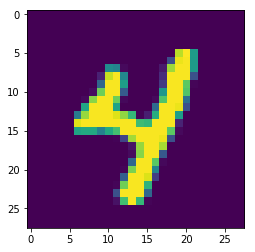

In [5]:
index = 25000
plt.imshow(train_set_x[index])

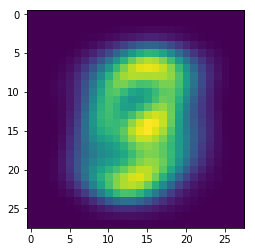

In [6]:
mean_image_from_train_set = train_set_x.mean(axis=0)
#print(mean_image_from_train_set)
#print(mean_image_from_train_set.shape)
plt.imshow(mean_image_from_train_set)

In [7]:
def meanSubtraction(train_x, test_x, mean_image):
    train_X = train_x - mean_image
    test_X = test_x - mean_image
    return train_X, test_X
train_set_x_mean_subtracted, test_set_x_mean_subtracted = meanSubtraction(train_set_x, test_set_x, mean_image_from_train_set )
train_set_x_reshaped = train_set_x_mean_subtracted.reshape((train_set_x_mean_subtracted.shape[0], 28 * 28))
test_set_x_reshaped = test_set_x_mean_subtracted.reshape((test_set_x_mean_subtracted.shape[0], 28 * 28))
print(train_set_x_reshaped.shape)
print(test_set_x_reshaped.shape)

(60000, 784)
(10000, 784)


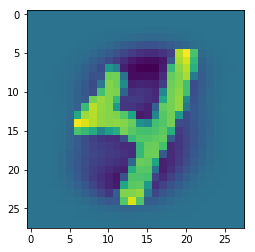

In [8]:
index = 25000
plt.imshow(train_set_x_mean_subtracted[index])

In [9]:
test_data = np.random.permutation(np.array(list(zip(test_set_x_reshaped,test_set_y))))
print(test_data.shape)
x = test_data[:,0]
y = test_data[:,1]
rand_X_subset = x[0:2000]
rand_Y_subset = y[0:2000]
print (np.unique(rand_Y_subset))
tsne_data = np.random.permutation(np.array(list(zip(rand_X_subset,rand_Y_subset))))
tsne_data.shape

(10000, 2)
[0 1 2 3 4 5 6 7 8 9]


(2000, 2)

<h1>First Experiment</h1>

At epoch  0 loss is:  1.8998398044199436 accuracy is:  0.40265


c:\python36\lib\site-packages\ipykernel_launcher.py:206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.3999
At epoch  1 loss is:  1.7718883052912024 accuracy is:  0.5006666666666667
At epoch  1 validation accuracy is  0.4968
At epoch  2 loss is:  1.6789178596444279 accuracy is:  0.5478166666666666
At epoch  2 validation accuracy is  0.5552
At epoch  3 loss is:  1.6085782511001836 accuracy is:  0.5729666666666666
At epoch  3 validation accuracy is  0.5745
At epoch  4 loss is:  1.5547817606109926 accuracy is:  0.5936
At epoch  4 validation accuracy is  0.5926
At epoch  5 loss is:  1.512083215777735 accuracy is:  0.6109333333333333
At epoch  5 validation accuracy is  0.6109
At epoch  6 loss is:  1.461103246951789 accuracy is:  0.6305
At epoch  6 validation accuracy is  0.6255
At epoch  7 loss is:  1.413191910552545 accuracy is:  0.6441666666666667
At epoch  7 validation accuracy is  0.6428
At epoch  8 loss is:  1.3770255178071817 accuracy is:  0.6660166666666667
At epoch  8 validation accuracy is  0.6662
At epoch  9 loss is:  1.340575467233013 accuracy

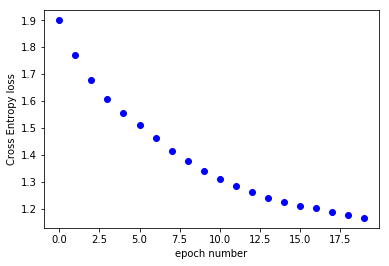

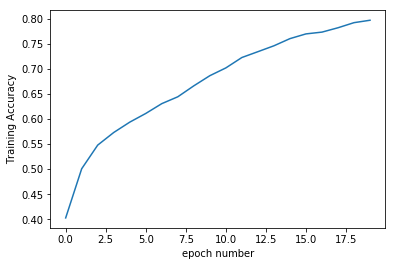

c:\python36\lib\site-packages\ipykernel_launcher.py:222: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


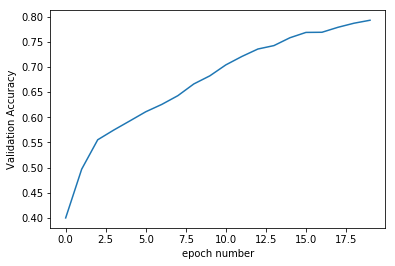

In [179]:
model1 = Neural_Network(2,784,[128,64,10], 'tanh')
lr = 3
dropout = 1 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model1.saveModel('task3_tanh_bestmodel.mdl')
model1.train(train_set_x_reshaped, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_reshaped, validationY = test_set_y)

In [180]:
model1.saveModel('task3_tanh_bestmodel.mdl')

2000
2000
-5.531212621185378
(2000, 64)
(2000, 64)


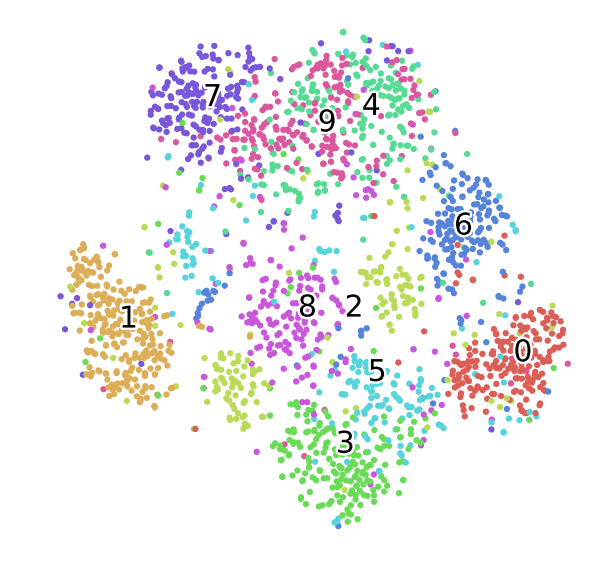

In [181]:
model1.T_SNE(tsne_data)

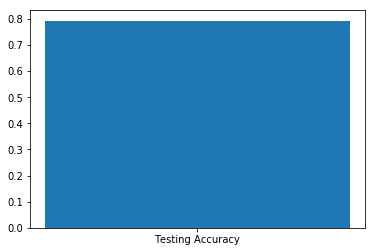

0.7928

In [183]:
test_accuracy = model1.accuracy(test_data,test = True)
test_accuracy

<h1>Reporting accuracy without dropout</h1>

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


At epoch  0 loss is:  2.0154728865492135 accuracy is:  0.13801666666666668


c:\python36\lib\site-packages\ipykernel_launcher.py:206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.1412
At epoch  1 loss is:  1.8775089175344322 accuracy is:  0.2146
At epoch  1 validation accuracy is  0.2122
At epoch  2 loss is:  1.797689275881178 accuracy is:  0.63335
At epoch  2 validation accuracy is  0.6286
At epoch  3 loss is:  1.7322754427912153 accuracy is:  0.7105666666666667
At epoch  3 validation accuracy is  0.7091
At epoch  4 loss is:  1.7024026794078002 accuracy is:  0.74645
At epoch  4 validation accuracy is  0.7443
At epoch  5 loss is:  1.6820771338052052 accuracy is:  0.76785
At epoch  5 validation accuracy is  0.7661
At epoch  6 loss is:  1.666632536835777 accuracy is:  0.7871333333333334
At epoch  6 validation accuracy is  0.7871
At epoch  7 loss is:  1.6547113302706338 accuracy is:  0.8006166666666666
At epoch  7 validation accuracy is  0.7977
At epoch  8 loss is:  1.6449976274029077 accuracy is:  0.8120333333333334
At epoch  8 validation accuracy is  0.8061
At epoch  9 loss is:  1.637730327939732 accuracy is:  0.817966666666

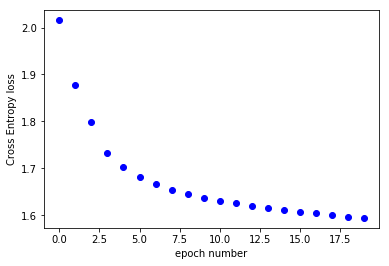

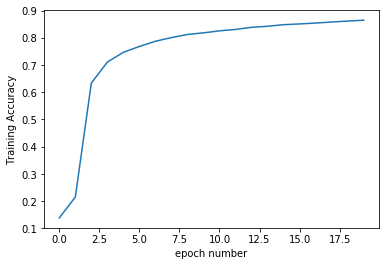

c:\python36\lib\site-packages\ipykernel_launcher.py:222: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


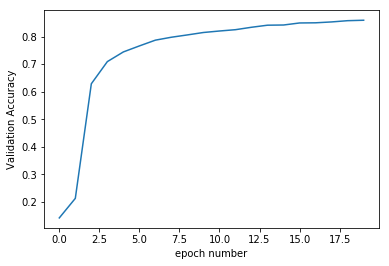

In [186]:
model3 = Neural_Network(2,784,[128,64,10], 'sigmoid')
model3.saveModel('task3_sigmoid_bestmodel.mdl')
# try different combinations of epochs and learning rate
lr = 3
dropout = 1 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model3.train(train_set_x_reshaped, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_reshaped, validationY = test_set_y)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


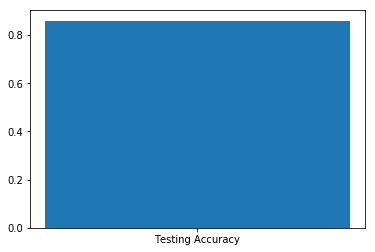

0.8594

In [203]:
#model3.saveModel('task3_sigmoid_bestmodel.mdl')
#model3.T_SNE(tsne_data)
test_accuracy = model3.accuracy(test_data,test = True)
test_accuracy

In [ ]:
test_accuracy = model3.accuracy(test_data,test = True)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


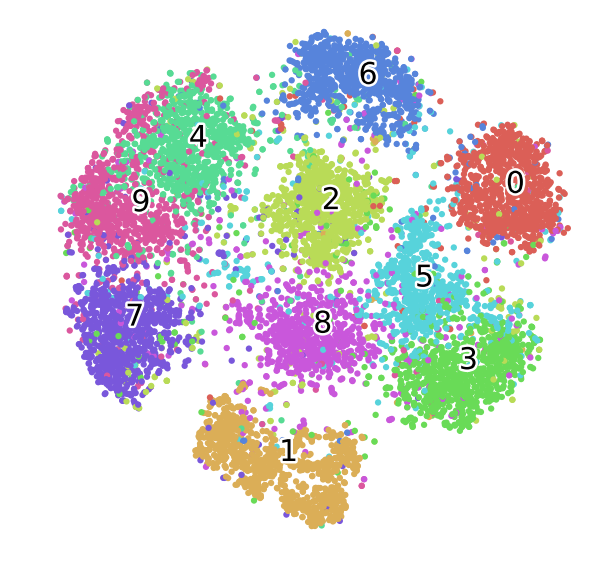

In [188]:
model3.T_SNE(test_data)

<h1>Reporting accuracy with dropout</h1>

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


At epoch  0 loss is:  1.9973295778587434 accuracy is:  0.3965


c:\python36\lib\site-packages\ipykernel_launcher.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.385
At epoch  1 loss is:  1.83953436287322 accuracy is:  0.5881166666666666
At epoch  1 validation accuracy is  0.5813
At epoch  2 loss is:  1.7774177555380088 accuracy is:  0.66705
At epoch  2 validation accuracy is  0.6649
At epoch  3 loss is:  1.7410091642774619 accuracy is:  0.7174833333333334
At epoch  3 validation accuracy is  0.7146
At epoch  4 loss is:  1.7179021104905083 accuracy is:  0.7478
At epoch  4 validation accuracy is  0.7473
At epoch  5 loss is:  1.698949747349323 accuracy is:  0.7701333333333333
At epoch  5 validation accuracy is  0.7703
At epoch  6 loss is:  1.6848257097445822 accuracy is:  0.7854333333333333
At epoch  6 validation accuracy is  0.7875
At epoch  7 loss is:  1.672542376526297 accuracy is:  0.7985166666666667
At epoch  7 validation accuracy is  0.7978
At epoch  8 loss is:  1.6614825785731908 accuracy is:  0.8084833333333333
At epoch  8 validation accuracy is  0.8105
At epoch  9 loss is:  1.6533233367051128 accuracy

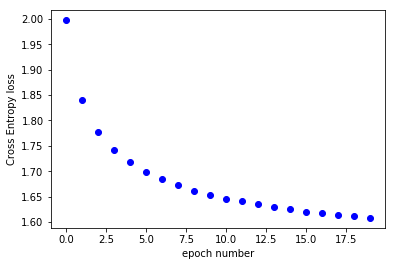

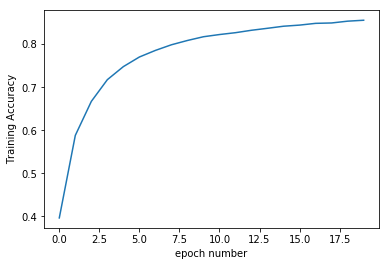

c:\python36\lib\site-packages\ipykernel_launcher.py:233: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


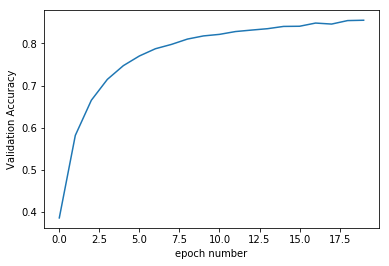

In [232]:
model2 = Neural_Network(2,784,[128,64,10], 'sigmoid')
model2.saveModel('task3_tanh_with_dropout_bestmodel.mdl')
# try different combinations of epochs and learning rate
lr = 3
dropout = 0.8 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model2.train(train_set_x_reshaped, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_reshaped, validationY = test_set_y)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


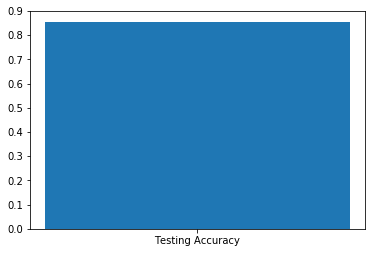

pred_y.shape
(10000,)
4
actual_y.shape
(10000,)
4


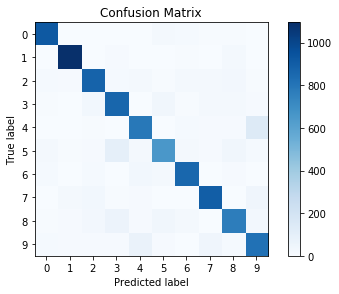

0.8553

In [233]:
model2.saveModel('task3_tanh_with_dropout_bestmodel.mdl')
#model2.T_SNE(tsne_data)
test_accuracy = model2.accuracy(test_data,test = True)
test_accuracy

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


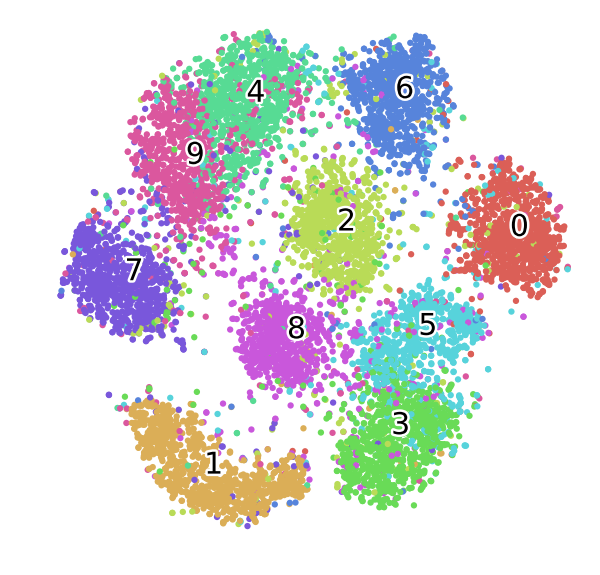

In [234]:
model2.T_SNE(test_data)

<h1> Reporting accuracy by changing number of neurons in hidden layers</h1>

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


At epoch  0 loss is:  2.0290802462490527 accuracy is:  0.24646666666666667


c:\python36\lib\site-packages\ipykernel_launcher.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.2573
At epoch  1 loss is:  1.8089987678026913 accuracy is:  0.62645
At epoch  1 validation accuracy is  0.6283
At epoch  2 loss is:  1.7402891880168303 accuracy is:  0.7069166666666666
At epoch  2 validation accuracy is  0.7091
At epoch  3 loss is:  1.7071307640532933 accuracy is:  0.74425
At epoch  3 validation accuracy is  0.7478
At epoch  4 loss is:  1.6847955840845457 accuracy is:  0.7695666666666666
At epoch  4 validation accuracy is  0.7714
At epoch  5 loss is:  1.6690342637705313 accuracy is:  0.7880666666666667
At epoch  5 validation accuracy is  0.7939
At epoch  6 loss is:  1.656013267642969 accuracy is:  0.8027
At epoch  6 validation accuracy is  0.8029
At epoch  7 loss is:  1.6461857748201405 accuracy is:  0.8116833333333333
At epoch  7 validation accuracy is  0.8104
At epoch  8 loss is:  1.63807258025806 accuracy is:  0.8205833333333333
At epoch  8 validation accuracy is  0.8177
At epoch  9 loss is:  1.6306004118075035 accuracy is:  0.8

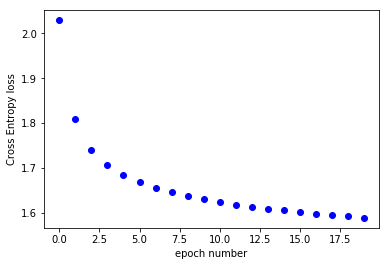

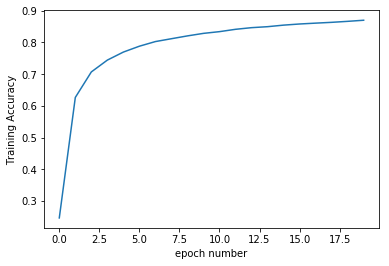

c:\python36\lib\site-packages\ipykernel_launcher.py:233: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


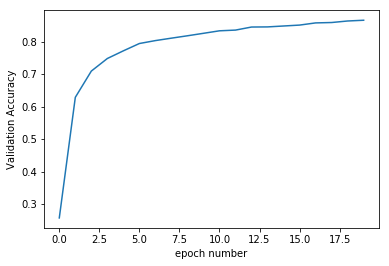

In [10]:
# report accuracy by changing number of neurons in hidden layers
model4 = Neural_Network(2,784,[256,100,10], 'sigmoid')
model4.saveModel('task3_sigmoid_moreNeurons_bestmodel.mdl')
# try different combinations of epochs and learning rate
lr = 3
dropout = 1 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model4.train(train_set_x_reshaped, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_reshaped, validationY = test_set_y)

In [11]:
model4.saveModel('task3_sigmoid_moreNeurons_bestmodel.mdl')
#model4.T_SNE(tsne_data)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


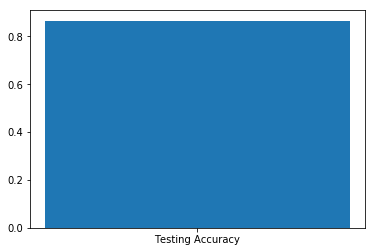

[[ 920    0    7    2    1   23   15    3    6    3]
 [   0 1090    5    5    1    5    4    2   23    0]
 [  26    2  856   28   14    5   22   27   44    8]
 [  11    2   30  847    3   41    5   23   38   10]
 [   3    3    5    3  839    6   21    6   12   84]
 [  16    3    7   58   13  712   20   13   35   15]
 [  14    4   19    2   17   16  873    4    7    2]
 [   4   14   29    4   14    5    2  903   11   42]
 [  13   10   22   44   22   36   11   14  779   23]
 [  14    7   12   15   68    9    2   33   13  836]]


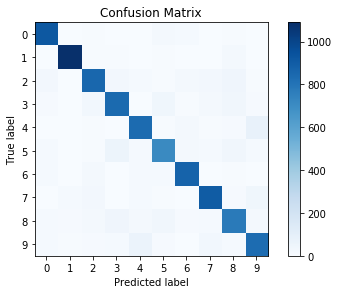

0.8655

In [12]:
test_accuracy = model4.accuracy(test_data,test = True)
test_accuracy

<h1>Changing number of hidden layers to see its effect on t-sne</h1>

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


At epoch  0 loss is:  1.9602176328511878 accuracy is:  0.4856333333333333


c:\python36\lib\site-packages\ipykernel_launcher.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.4865
At epoch  1 loss is:  1.8562152658298225 accuracy is:  0.5928833333333333
At epoch  1 validation accuracy is  0.599
At epoch  2 loss is:  1.8097132625239933 accuracy is:  0.6417
At epoch  2 validation accuracy is  0.6516
At epoch  3 loss is:  1.7800953965461797 accuracy is:  0.6719666666666667
At epoch  3 validation accuracy is  0.6741
At epoch  4 loss is:  1.7589896960088671 accuracy is:  0.69345
At epoch  4 validation accuracy is  0.6924
At epoch  5 loss is:  1.7445137034347324 accuracy is:  0.7078333333333333
At epoch  5 validation accuracy is  0.7044
At epoch  6 loss is:  1.7312977279959016 accuracy is:  0.72085
At epoch  6 validation accuracy is  0.7167
At epoch  7 loss is:  1.7210736203806891 accuracy is:  0.7319166666666667
At epoch  7 validation accuracy is  0.7282
At epoch  8 loss is:  1.7118538137161838 accuracy is:  0.7390833333333333
At epoch  8 validation accuracy is  0.7342
At epoch  9 loss is:  1.704954313496001 accuracy is:  0.

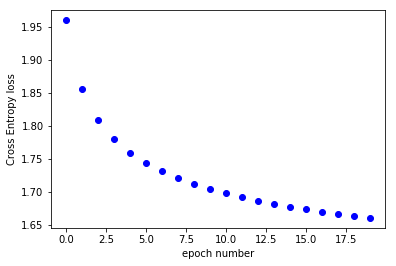

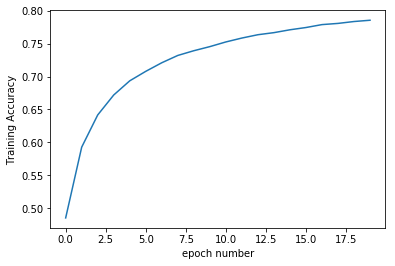

c:\python36\lib\site-packages\ipykernel_launcher.py:233: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


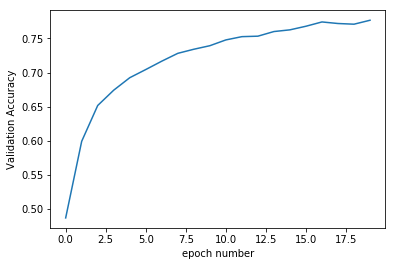

In [200]:
# change number of hidden layers and see its effect on t-sne
model5 = Neural_Network(3,784,[256,128,64,10], 'sigmoid')
model5.saveModel('task3_sigmoid_moreLayers_bestmodel.mdl')
# try different combinations of epochs and learning rate
lr = 3
dropout = 1 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model5.train(train_set_x_reshaped, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_reshaped, validationY = test_set_y)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


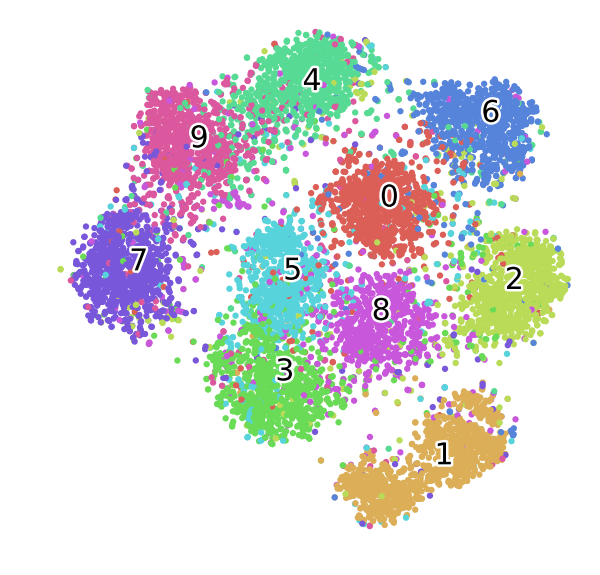

In [205]:
model5.T_SNE(test_data)

<h1>Reporting results without Mean-subtraction</h1>

In [211]:
train_set_x_NO_MS = train_set_x.reshape((train_set_x.shape[0], 28 * 28))
test_set_x_NO_MS = test_set_x.reshape((test_set_x.shape[0], 28 * 28))

In [212]:
test_data_NO_MS = np.random.permutation(np.array(list(zip(test_set_x_NO_MS,test_set_y))))
print(test_data_NO_MS.shape)
x_NO_MS = test_data_NO_MS[:,0]
y_NO_MS = test_data_NO_MS[:,1]
rand_X_subset_NO_MS = x_NO_MS[0:2000]
rand_Y_subset_NO_MS = y_NO_MS[0:2000]
print (np.unique(rand_Y_subset_NO_MS))
tsne_data_NO_MS = np.random.permutation(np.array(list(zip(rand_X_subset_NO_MS,rand_Y_subset_NO_MS))))
tsne_data_NO_MS.shape

(10000, 2)
[0 1 2 3 4 5 6 7 8 9]


(2000, 2)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


At epoch  0 loss is:  2.0770154191907855 accuracy is:  0.3857833333333333


c:\python36\lib\site-packages\ipykernel_launcher.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


At epoch  0 validation accuracy is  0.382
At epoch  1 loss is:  1.9091606517773023 accuracy is:  0.5550833333333334
At epoch  1 validation accuracy is  0.567
At epoch  2 loss is:  1.8426088802638596 accuracy is:  0.6258833333333333
At epoch  2 validation accuracy is  0.6346
At epoch  3 loss is:  1.8046834158485667 accuracy is:  0.6587666666666666
At epoch  3 validation accuracy is  0.6697
At epoch  4 loss is:  1.7835406085792227 accuracy is:  0.67745
At epoch  4 validation accuracy is  0.6907
At epoch  5 loss is:  1.769022147873076 accuracy is:  0.6901166666666667
At epoch  5 validation accuracy is  0.701
At epoch  6 loss is:  1.7559947720897389 accuracy is:  0.7014666666666667
At epoch  6 validation accuracy is  0.7102
At epoch  7 loss is:  1.7417657591359967 accuracy is:  0.71685
At epoch  7 validation accuracy is  0.721
At epoch  8 loss is:  1.733332076054067 accuracy is:  0.7259666666666666
At epoch  8 validation accuracy is  0.7285
At epoch  9 loss is:  1.7234157307932652 accuracy

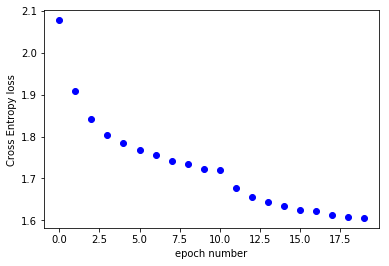

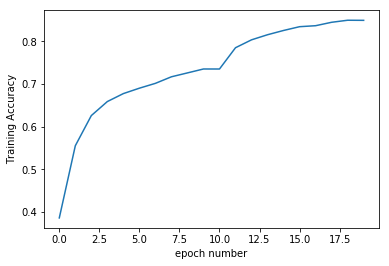

c:\python36\lib\site-packages\ipykernel_launcher.py:233: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


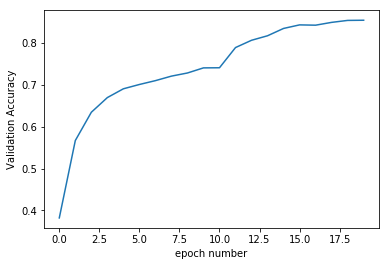

In [230]:
model7 = Neural_Network(2,784,[128,64,10], 'sigmoid')
model7.saveModel('task3_sigmoid_NO_MS_bestmodel.mdl')
# try different combinations of epochs and learning rate
lr = 3
dropout = 1 # it is actually keep_prob in my code
batchSize = 1000
epochs = 20
classes = 10
model7.train(train_set_x_NO_MS, train_set_y,learning_rate = lr, drop_out = dropout,batch_size=batchSize, 
            training_epochs=epochs,plot_err = True , validationX = test_set_x_NO_MS, validationY = test_set_y)

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


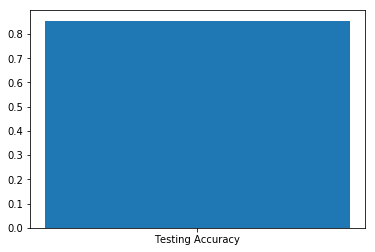

pred_y.shape
(10000,)
3
actual_y.shape
(10000,)
3


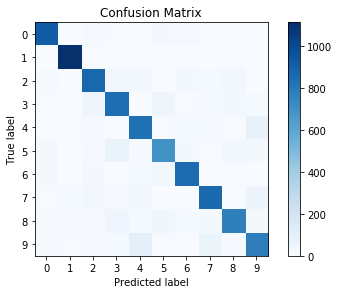

0.8546

In [231]:
model7.saveModel('task3_sigmoid_NO_MS_bestmodel.mdl')
test_accuracy = model7.accuracy(test_data_NO_MS,test = True)
test_accuracy

c:\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


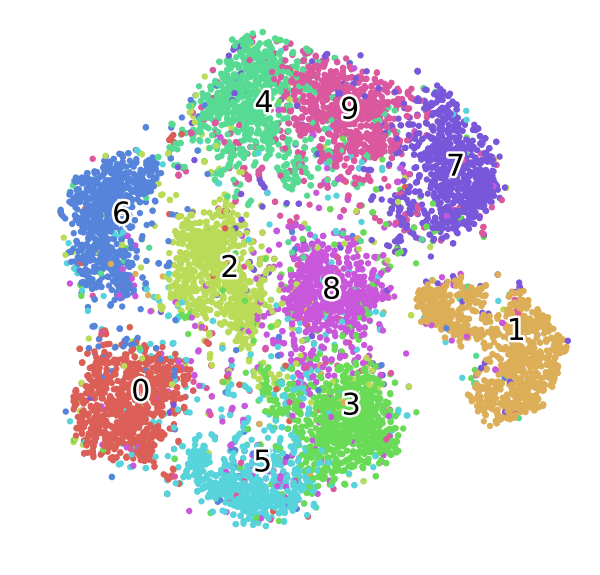

In [235]:
model7.T_SNE(test_data_NO_MS)

#### Note: This below section will be used for the evaluation of this task, we need your model and we will run script below to evaluated your model

In [ ]:
# create class object
mm = Neural_Network()
# load model which will be provided by you
loaded_model = mm.loadModel('task3_bestmodel.mdl')
# check accuracy of that model
loaded_model.accuracy(test_set_x_reshaped,test_set_y,test=True)


